In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from lib import jsoncorpus, datastuff, analysis
import gensim
import traceback
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, FeatureUnion
import sklearn.preprocessing
import sklearn.cross_validation
import sklearn.ensemble
import sklearn.svm
import sklearn.decomposition
from lib.scikitComponents import *
import itertools
import collections
from lib.scikitComponents import pipelines

## Data preprocessing

In [3]:
# Load in the previously created corpus and dictionary of scraped sites
#dictionary, corpus, meta_corpus, dmoz_data = jsoncorpus.load_or_create('docs/sites.jl')
dictionary, corpus, meta_corpus, dmoz_data = jsoncorpus.load_or_create('docs/sites.jl', stemmed=True, prefix="stemmed_")

Done.


In [4]:
# Set up array of input data
X = zip(list(corpus), list(meta_corpus), dmoz_data['meta'])
# Link topics to URLs
meta = list(zip(dmoz_data['urls'], dmoz_data['dmoz_categories']))
# Encode class labels
classes, top_categories, dmoz_encoder = datastuff.encode_dmoz_categories(dmoz_data['dmoz_categories'])

verbosity = 0

## Get the scores of different combinations of classifiers

In [5]:
# Just TFIDF on metadata, LinearSVC
clf1 = pipelines.make_classifier(dictionary, body_kind=None, meta_kind='tfidf', classifier = 'svc')
scores = sklearn.cross_validation.cross_val_score(clf1, X, classes, cv=5, verbose=verbosity)
analysis.print_score_accuracy(scores)

Accuracy: 0.46 (+/- 0.08)


In [6]:
# Just word-count on metadata, LinearSVC
clf2 = pipelines.make_classifier(dictionary, body_kind=None, meta_kind='count', classifier='svc')
scores = sklearn.cross_validation.cross_val_score(clf2, X, classes, cv=5, verbose=verbosity)
analysis.print_score_accuracy(scores)

Accuracy: 0.35 (+/- 0.06)


In [7]:
# Just TFIDF on body, LinearSVC
clf3 = pipelines.make_classifier(dictionary, body_kind='tfidf', meta_kind=None, classifier = 'svc')
scores = sklearn.cross_validation.cross_val_score(clf3, X, classes, cv=5, verbose=verbosity)
analysis.print_score_accuracy(scores)

Accuracy: 0.52 (+/- 0.08)


In [8]:
# Just LDA on body, LinearSVC
clf4 = pipelines.make_classifier(dictionary, body_kind='lda', meta_kind=None, classifier = 'svc')
scores = sklearn.cross_validation.cross_val_score(clf4, X, classes, cv=5, verbose = verbosity)
analysis.print_score_accuracy(scores)

Accuracy: 0.38 (+/- 0.04)


In [9]:
# TFIDF on body and metadata, LinearSVC
clf5 = pipelines.make_classifier(dictionary, body_kind='tfidf', meta_kind='tfidf', classifier = 'svc')
scores = sklearn.cross_validation.cross_val_score(clf5, X, classes, cv=5, verbose = verbosity)
analysis.print_score_accuracy(scores)

Accuracy: 0.54 (+/- 0.07)


## Do some analysis on a single test/train split

### Find the score for each category. 

Note that if the classifier assigned *random* categories, the score would be $\frac{1}{\textrm{num categories}}$. Instead, it is actually quite high in some cases, indicating a moderate amount of success (given how naive this is!)

In [150]:
X_train, X_test, y_train, y_test = datastuff.tt_split(X, classes, test_size = 0.2)
clf = pipelines.make_classifier(dictionary, meta_kind='tfidf', body_kind='tfidf', classifier = 'svc')
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
print sklearn.metrics.classification_report(dmoz_encoder.inverse_transform(y_test), dmoz_encoder.inverse_transform(predicted), dmoz_encoder.classes_)


             precision    recall  f1-score   support

       arts       0.81      0.72      0.76        36
   business       0.68      0.72      0.70        50
  computers       0.76      0.85      0.80        59
      games       0.86      0.82      0.84        22
     health       0.66      0.73      0.69        26
       home       0.83      0.62      0.71        39
kids and teens       0.67      0.55      0.60        11
       news       0.74      0.71      0.73        28
 recreation       0.77      0.72      0.75        47
  reference       0.62      0.62      0.62        56
   regional       1.00      0.50      0.67         2
    science       0.73      0.78      0.76        60
   shopping       0.80      0.74      0.77        27
    society       0.53      0.42      0.47        40
     sports       0.82      0.95      0.88        97

avg / total       0.74      0.74      0.74       600



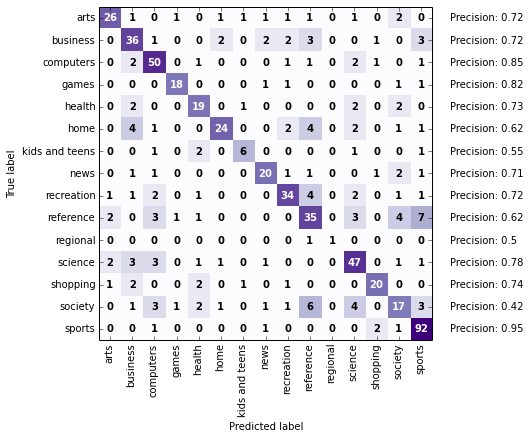

In [151]:
cm = sklearn.metrics.confusion_matrix(dmoz_encoder.inverse_transform(y_test), dmoz_encoder.inverse_transform(predicted), dmoz_encoder.classes_)
analysis.plot_confusion_matrix(cm, labels=dmoz_encoder.classes_, title=None, cmap=plt.cm.Purples)
#plt.savefig('confusion_tfidf-proportional-trees.pdf', bbox_inches='tight')
plt.show()

### How good are the top N guesses?

Testing "TFIDF(body and meta)" classifier
Testing "TFIDF(meta)" classifier
Testing "TFIDF(body)" classifier
Testing "WordCount(meta)+LDA(body)" classifier
Testing "LDA(body)" classifier
Testing "WordCount(meta)" classifier


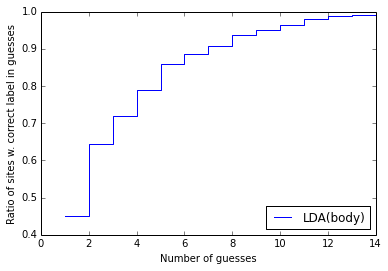

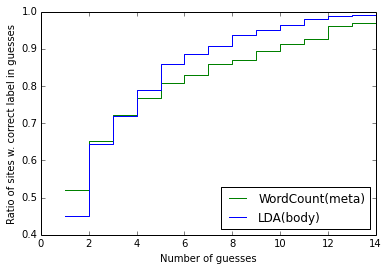

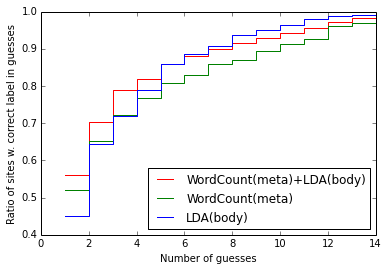

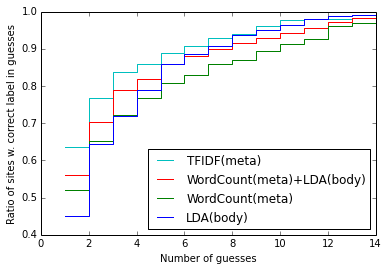

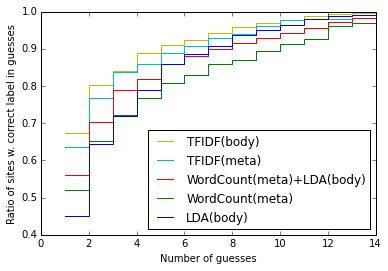

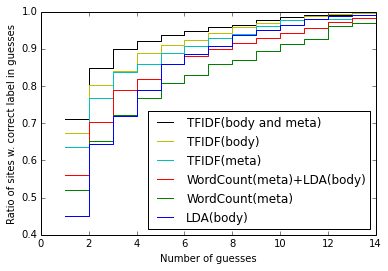

In [8]:
X_train, X_test, y_train, y_test = datastuff.tt_split(X, classes, test_size = 0.25)
clfs = [
    pipelines.make_classifier(dictionary, meta_kind='tfidf', body_kind='tfidf', classifier = 'svc'),
    pipelines.make_classifier(dictionary, meta_kind='tfidf', body_kind=None, classifier = 'svc'),
    pipelines.make_classifier(dictionary, meta_kind=None, body_kind='tfidf', classifier = 'svc'),
    pipelines.make_classifier(dictionary, meta_kind='count', body_kind='lda', classifier = 'svc'),
    pipelines.make_classifier(dictionary, meta_kind=None, body_kind='lda', classifier = 'svc'),
    pipelines.make_classifier(dictionary, meta_kind='count', body_kind=None, classifier = 'svc')
]
legends = ['TFIDF(body and meta)', 'TFIDF(meta)', 'TFIDF(body)', 'WordCount(meta)+LDA(body)', 'LDA(body)', 'WordCount(meta)']
accuracies = []
colors = ['b','g','r','c','y','k']

for legend, clf in zip(legends, clfs):
    print "Testing \"{}\" classifier".format(legend)
    clf.fit(X_train, y_train)
    accuracies.append(analysis.accuracy_of_top_n_guesses(clf, X_test, y_test))

inds = np.argsort([a[0] for a in accuracies])
accuracies = np.array(accuracies)[inds]
clfs = np.array(clfs)[inds]
legends = np.array(legends)[inds]
    
for i in range(len(clfs)):
    f = plt.figure()
    lines = [plt.step(range(1, len(accuracies[j])+1),accuracies[j], c = colors[j], where='post')[0]
             for j in range(i, -1, -1)]
    legs = legends[:i+1][::-1]
    #print lines, legs

    plt.legend(lines, legs, loc='lower right')
    plt.ylim((0.4, 1))
    plt.ylabel('Ratio of sites w. correct label in guesses')
    plt.xlabel('Number of guesses')
    plt.show()
    #plt.savefig('classifier-n-guesses_{}.pdf'.format(i), bbox_inches='tight')


In [198]:
d, c, m, dmoz_data = jsoncorpus.load_or_create('docs/sites.jl', stemmed=True, prefix="stemmed_")
#d, c, m, dmoz_data = jsoncorpus.load_or_create('docs/sites.jl')
[i for i, q in enumerate(meta) if 'skinet' in q[0]]

print "BODY"
arr = sorted([(d[w], int(count)) for w, count in c[185]])
print ", ".join("{}~({})".format(w, c) for w, c in arr)

print "META"
arr = sorted([(d[w], int(count)) for w, count in m[185]])
print ", ".join("{}~({})".format(w, c) for w, c in arr)


Done.
BODY
101~(1), 1949~(1), 1968~(1), 2015~(2), 31~(1), 66~(2), abus~(2), acl~(1), activ~(1), advic~(1), aid~(1), airbag~(1), aliv~(1), audienc~(1), avalanch~(2), bar~(1), bay~(1), bc~(1), big~(1), blow~(1), brave~(1), break~(1), british~(1), bum~(1), champ~(1), code~(1), columbia~(1), compani~(1), copyright~(1), crack~(1), creat~(1), cruz~(1), deepest~(1), dream~(1), elk~(1), enjoy~(1), entertain~(1), excit~(1), exot~(1), explor~(1), famili~(1), film~(2), financi~(2), fli~(1), friend~(1), gear~(2), goal~(1), grand~(1), great~(1), group~(1), hotel~(1), idea~(2), inspir~(1), interest~(1), jump~(1), lab~(1), largest~(1), latest~(1), lifetim~(1), locat~(2), luxuri~(1), magazin~(5), massiv~(1), media~(1), meet~(1), midwest~(1), miller~(4), mountain~(2), network~(1), nevada~(1), organ~(1), perform~(1), polici~(1), powder~(2), privaci~(1), publish~(1), race~(1), record~(1), recreat~(1), region~(1), reno~(1), review~(1), safer~(1), scene~(1), servic~(1), set~(1), shot~(1), ski~(13), skier~(

[(39, 4.0),
 (168, 1.0),
 (605, 1.0),
 (713, 2.0),
 (945, 2.0),
 (1012, 1.0),
 (1033, 1.0),
 (1161, 2.0),
 (1187, 1.0),
 (1190, 1.0),
 (1345, 1.0),
 (1427, 1.0),
 (1583, 1.0),
 (1700, 1.0),
 (1834, 1.0),
 (2005, 1.0),
 (2248, 1.0),
 (2388, 1.0),
 (2484, 1.0),
 (2611, 4.0),
 (2620, 2.0),
 (2640, 1.0),
 (2711, 1.0),
 (3016, 1.0),
 (3088, 1.0),
 (3143, 2.0),
 (3421, 1.0),
 (3472, 1.0),
 (3510, 1.0),
 (3591, 1.0),
 (3636, 1.0),
 (3734, 1.0),
 (3773, 1.0),
 (3883, 1.0),
 (4067, 1.0),
 (4262, 5.0),
 (4321, 1.0),
 (4365, 1.0),
 (4562, 1.0),
 (4908, 1.0),
 (4990, 1.0),
 (4996, 1.0),
 (5061, 1.0),
 (5226, 1.0),
 (5300, 1.0),
 (5312, 1.0),
 (5351, 1.0),
 (5505, 1.0),
 (5636, 1.0),
 (5719, 1.0),
 (5879, 1.0),
 (6461, 1.0),
 (6675, 1.0),
 (6772, 1.0),
 (6805, 1.0),
 (6884, 1.0),
 (6912, 1.0),
 (7362, 1.0),
 (7459, 1.0),
 (7461, 1.0),
 (7473, 2.0),
 (7619, 1.0),
 (7660, 1.0),
 (8007, 2.0),
 (8105, 1.0),
 (8207, 1.0),
 (8422, 2.0),
 (8606, 1.0),
 (8636, 1.0),
 (8638, 1.0),
 (8684, 1.0),
 (8921, 2.0)